[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Using device: cuda
Building vocabulary...
Vocabulary size: 2158
Total images with descriptions: 31590
Training images: 25272
Validation images: 6318


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 211MB/s] 



Starting training for Image Captioning...


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/20], Train Loss: 1.9556, Val Loss: 1.3689, Val Accuracy: 64.69%
Epoch [2/20], Train Loss: 1.0420, Val Loss: 0.8789, Val Accuracy: 75.97%
Epoch [3/20], Train Loss: 0.6600, Val Loss: 0.6189, Val Accuracy: 82.79%
Epoch [4/20], Train Loss: 0.4741, Val Loss: 0.4900, Val Accuracy: 85.65%
Epoch [5/20], Train Loss: 0.3823, Val Loss: 0.4297, Val Accuracy: 87.39%
Epoch [6/20], Train Loss: 0.3279, Val Loss: 0.3826, Val Accuracy: 88.41%
Epoch [7/20], Train Loss: 0.2894, Val Loss: 0.3666, Val Accuracy: 88.67%
Epoch [8/20], Train Loss: 0.2620, Val Loss: 0.3521, Val Accuracy: 88.86%
Epoch [9/20], Train Loss: 0.2382, Val Loss: 0.3341, Val Accuracy: 89.43%
Epoch [10/20], Train Loss: 0.2193, Val Loss: 0.3287, Val Accuracy: 89.61%
Epoch [11/20], Train Loss: 0.2041, Val Loss: 0.3149, Val Accuracy: 90.09%
Epoch [12/20], Train Loss: 0.1884, Val Loss: 0.3142, Val Accuracy: 90.06%
Epoch [13/20], Train Loss: 0.1766, Val Loss: 0.3152, Val Accuracy: 90.16%
Epoch [14/20], Train Loss: 0.1656, Val Loss: 0.

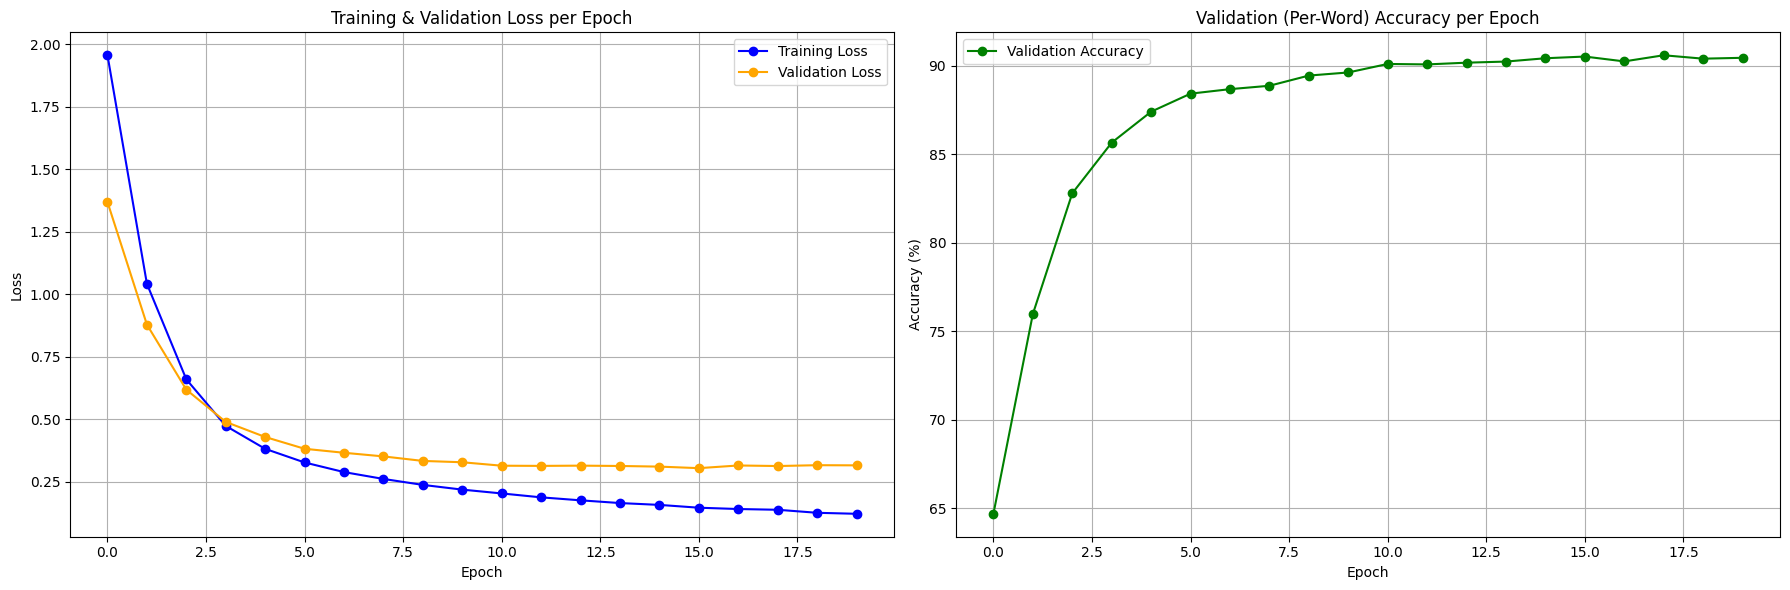

In [1]:
# ==============================================================================
# Step 1: Setup and Imports
# ==============================================================================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torch.nn.utils.rnn import pad_sequence
from torchvision import models, transforms
from PIL import Image
import pandas as pd
import os
import nltk
from collections import Counter
import matplotlib.pyplot as plt

# Download the tokenizer models
nltk.download('punkt')

# Check if a GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# ==============================================================================
# Step 2: Build the Vocabulary
# ==============================================================================

class Vocabulary:
    """Builds a mapping from words to integer indices."""
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<START>", 2: "<END>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<START>": 1, "<END>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    def build_vocabulary(self, sentence_list):
        word_counts = Counter()
        idx = 4 # Start index after special tokens

        for sentence in sentence_list:
            for word in nltk.word_tokenize(sentence.lower()):
                word_counts[word] += 1
                if word_counts[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1
    
    def numericalize(self, text):
        tokenized_text = nltk.word_tokenize(text.lower())
        numericalized = [self.stoi["<START>"]]
        numericalized.extend([self.stoi.get(word, self.stoi["<UNK>"]) for word in tokenized_text])
        numericalized.append(self.stoi["<END>"])
        return numericalized


# ==============================================================================
# Step 3: Prepare Your Dataset and DataLoader
# ==============================================================================

class JewelryDatasetCSV(Dataset):
    """Custom Dataset for loading jewelry images and captions from a CSV file."""
    def __init__(self, csv_file, root_dir, vocab, transform=None):
        self.annotations = pd.read_csv(csv_file).dropna(subset=['description'])
        self.root_dir = root_dir
        self.transform = transform
        self.vocab = vocab

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_rel_path = self.annotations.iloc[index]['image_path']
        img_full_path = os.path.join(self.root_dir, img_rel_path)
        
        try:
            image = Image.open(img_full_path).convert('RGB')
        except FileNotFoundError:
            print(f"Warning: Image not found at {img_full_path}. Skipping.")
            return None

        if self.transform:
            image = self.transform(image)
            
        caption_str = self.annotations.iloc[index]['description']
        numerical_caption = self.vocab.numericalize(caption_str)
        return image, torch.tensor(numerical_caption)

class Collate_fn:
    """Pads captions in a batch to the same length."""
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        batch = list(filter(lambda x: x is not None, batch))
        if not batch:
            return torch.Tensor(), torch.Tensor()

        images = [item[0].unsqueeze(0) for item in batch]
        images = torch.cat(images, dim=0)
        
        captions = [item[1] for item in batch]
        captions_padded = pad_sequence(captions, batch_first=True, padding_value=self.pad_idx)
        return images, captions_padded

# --- Image transformations ---
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- Define Paths ---
CSV_FILE_PATH = '/kaggle/input/jewelry-images/augmented_dataset.csv'
IMAGE_ROOT_DIR = '/kaggle/input/jewelry-images/augment_images/content/Augment'

# --- Build Vocabulary ---
print("Building vocabulary...")
vocab = Vocabulary(freq_threshold=5) 
df = pd.read_csv(CSV_FILE_PATH).dropna(subset=['description'])
vocab.build_vocabulary(df['description'].tolist())
print(f"Vocabulary size: {len(vocab)}")

# --- Create Dataset ---
full_dataset = JewelryDatasetCSV(
    csv_file=CSV_FILE_PATH,
    root_dir=IMAGE_ROOT_DIR,
    vocab=vocab,
    transform=data_transforms
)

# --- Split Dataset ---
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

print(f"Total images with descriptions: {len(full_dataset)}")
print(f"Training images: {len(train_dataset)}")
print(f"Validation images: {len(val_dataset)}")

# --- Create DataLoaders ---
pad_idx = vocab.stoi["<PAD>"]
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=Collate_fn(pad_idx=pad_idx)
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=Collate_fn(pad_idx=pad_idx)
)


# ==============================================================================
# Step 4: Define the Encoder-Decoder Model
# ==============================================================================

class EncoderCNN(nn.Module):
    """Encoder: Uses a pre-trained VGG-16 to get image features."""
    def __init__(self, hidden_size):
        super(EncoderCNN, self).__init__()
        vgg16 = models.vgg16(pretrained=True)
        self.features = vgg16.features
        
        for param in self.features.parameters():
            param.requires_grad = False
            
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, hidden_size)

    def forward(self, images):
        x = self.features(images)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class DecoderRNN(nn.Module):
    """Decoder: Uses a GRU to generate captions word by word."""
    def __init__(self, embed_size, hidden_size, vocab_size):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.gru = nn.GRU(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions):
        captions_embed = self.embed(captions)
        hidden_state = features.unsqueeze(0)
        outputs, _ = self.gru(captions_embed, hidden_state)
        predictions = self.fc(outputs)
        return predictions


# ==============================================================================
# Step 5: Initialize Model and Training Components
# ==============================================================================

# Hyperparameters
embed_size = 256
hidden_size = 512 
vocab_size = len(vocab)
num_epochs = 20
learning_rate = 0.001

# Initialize models
encoder = EncoderCNN(hidden_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=vocab.stoi["<PAD>"])
params = list(decoder.parameters()) + list(encoder.fc.parameters())
optimizer = optim.Adam(params, lr=learning_rate)

# --- Lists to store training history ---
history_train_loss = []
history_val_loss = []
history_val_accuracy = []


# ==============================================================================
# Step 6: Training the Model (*** NOW INCLUDES ACCURACY ***)
# ==============================================================================

print("\nStarting training for Image Captioning...")

for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    
    running_loss = 0.0
    
    for images, captions in train_loader:
        if images.nelement() == 0: continue
            
        images, captions = images.to(device), captions.to(device)
        
        captions_input = captions[:, :-1]
        captions_target = captions[:, 1:]
        
        features = encoder(images)
        outputs = decoder(features, captions_input)
        
        outputs_flat = outputs.reshape(-1, outputs.shape[2])
        captions_flat = captions_target.reshape(-1)
        
        loss = criterion(outputs_flat, captions_flat)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        
    epoch_loss = running_loss / len(train_dataset)
    history_train_loss.append(epoch_loss)

    # --- Validation ---
    encoder.eval()
    decoder.eval()
    
    val_loss = 0.0
    total_words = 0
    correct_words = 0
    
    with torch.no_grad():
        for images, captions in val_loader:
            if images.nelement() == 0: continue
            
            images, captions = images.to(device), captions.to(device)
            
            captions_input = captions[:, :-1]
            captions_target = captions[:, 1:]
            
            features = encoder(images)
            outputs = decoder(features, captions_input)
            
            # Calculate Loss
            outputs_flat = outputs.reshape(-1, outputs.shape[2])
            captions_flat = captions_target.reshape(-1)
            loss = criterion(outputs_flat, captions_flat)
            val_loss += loss.item() * images.size(0)
            
            # --- Calculate Accuracy ---
            # Get the top prediction for each word
            _, predicted_indices = outputs.max(2) # Shape: (batch_size, seq_len)
            
            # Create a mask to ignore <PAD> tokens
            pad_mask = (captions_target != vocab.stoi["<PAD>"])
            
            # Count correct words (where prediction matches target AND it's not a pad token)
            correct_words += ((predicted_indices == captions_target) & pad_mask).sum().item()
            
            # Count total words (all non-pad tokens)
            total_words += pad_mask.sum().item()
            
    epoch_val_loss = val_loss / len(val_dataset)
    epoch_val_accuracy = 100 * (correct_words / total_words)
    
    history_val_loss.append(epoch_val_loss)
    history_val_accuracy.append(epoch_val_accuracy)
    
    # --- Print Epoch Results ---
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.2f}%')

print("Finished Training!")


# ==============================================================================
# Step 7: Save the Trained Model
# ==============================================================================
torch.save(encoder.state_dict(), 'encoder.pth')
torch.save(decoder.state_dict(), 'decoder.pth')

print(f"\nEncoder model saved to encoder.pth")
print(f"Decoder model saved to decoder.pth")


# ==============================================================================
# Step 8: Plot Training History (*** NOW INCLUDES ACCURACY PLOT ***)
# ==============================================================================
plt.figure(figsize=(18, 6))

# --- Plot 1: Loss ---
plt.subplot(1, 2, 1)
plt.plot(history_train_loss, label='Training Loss', color='blue', marker='o')
plt.plot(history_val_loss, label='Validation Loss', color='orange', marker='o')
plt.title('Training & Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# --- Plot 2: Accuracy ---
plt.subplot(1, 2, 2)
plt.plot(history_val_accuracy, label='Validation Accuracy', color='green', marker='o')
plt.title('Validation (Per-Word) Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# --- Save and Show ---
plt.tight_layout()
plt.savefig('captioning_training_plots.png')
print("\nTraining plots saved to captioning_training_plots.png")

In [2]:
pip install rembg onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 3.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mkl-fft to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of mkl-fft to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is looking at multiple versions of mkl-random to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of mkl-umath to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━

In [3]:
# ==============================================================================
# CELL 2: Interactive Prediction Widget (Silent White Background)
# ==============================================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import io
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

# 1. Install Background Removal Tool
try:
    from rembg import remove
except ImportError:
    print("Installing rembg...")
    !pip install rembg -q
    from rembg import remove

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Re-Define Models (Independent Cell)
# We redefine these so you can run this cell even if you restart the kernel
class EncoderCNN(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        vgg = models.vgg16(pretrained=False) # False because we load saved weights
        self.features = vgg.features
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, hidden_size)
    def forward(self, x):
        x = self.features(x)
        x = self.pool(x).view(x.size(0), -1)
        return self.fc(x)

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.gru = nn.GRU(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
    def forward(self, features, captions):
        embeds = self.embed(captions)
        features = features.unsqueeze(0)
        out, _ = self.gru(embeds, features)
        return self.fc(out)

# 3. Load Everything
if 'vocab' not in globals():
    raise ValueError("Error: 'vocab' not found. Please run Cell 1 first to build the vocabulary.")

embed_dim = 256
hidden_dim = 512
enc = EncoderCNN(hidden_dim).to(device)
dec = DecoderRNN(embed_dim, hidden_dim, len(vocab)).to(device)

try:
    # Load the models saved in Cell 1
    enc.load_state_dict(torch.load('encoder.pth', map_location=device))
    dec.load_state_dict(torch.load('decoder.pth', map_location=device))
    print("✅ Models loaded successfully.")
except FileNotFoundError:
    print("⚠️ Saved models not found. Using current in-memory models (if just trained).")

enc.eval()
dec.eval()

# Transforms for prediction
pred_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 4. Prediction Logic (White BG + Beam Search)
def predict_caption(image_path, beam_k=3):
    # A. Background Removal (Silent)
    try:
        raw_img = Image.open(image_path).convert("RGB")
        # Remove bg
        no_bg = remove(raw_img)
        # Paste on White
        white_bg = Image.new("RGB", no_bg.size, (255, 255, 255))
        white_bg.paste(no_bg, mask=no_bg.split()[3])
        input_img = white_bg
    except Exception as e:
        print(f"BG Removal failed ({e}), using original.")
        input_img = raw_img

    # B. Encode
    img_tensor = pred_transform(input_img).unsqueeze(0).to(device)
    with torch.no_grad():
        features = enc(img_tensor) # (1, 512)

    # C. Beam Search
    start_tok = vocab.stoi["<START>"]
    end_tok = vocab.stoi["<END>"]
    
    # Beams: [(score, [sequence])]
    beams = [(0, [start_tok])]
    
    for i in range(20): # Max length
        candidates = []
        
        for score, seq in beams:
            if seq[-1] == end_tok:
                candidates.append((score, seq))
                continue
            
            # Predict next word based on full sequence so far
            input_seq = torch.tensor([seq]).to(device)
            
            with torch.no_grad():
                # GRU uses image features as init hidden state
                outputs = dec(features, input_seq)
                last_word_logits = outputs[:, -1, :]
                
            log_probs = F.log_softmax(last_word_logits, dim=1)
            topk_probs, topk_ids = log_probs.topk(beam_k)
            
            for j in range(beam_k):
                word_idx = topk_ids[0, j].item()
                p = topk_probs[0, j].item()
                candidates.append((score + p, seq + [word_idx]))
        
        # Keep top k beams
        beams = sorted(candidates, key=lambda x: x[0], reverse=True)[:beam_k]
        if all(b[1][-1] == end_tok for b in beams): break
            
    best_seq = beams[0][1]
    words = [vocab.itos[idx] for idx in best_seq if idx not in [start_tok, end_tok, vocab.stoi["<PAD>"]]]
    return " ".join(words)

# 5. Widget
upload_btn = widgets.FileUpload(accept='image/*', multiple=False, description='Upload')
out = widgets.Output()

def on_upload(change):
    if not upload_btn.value: return
    # Get file
    f = upload_btn.value
    content = f[0]['content'] if isinstance(f, tuple) or isinstance(f, list) else next(iter(f.values()))['content']
    
    # Save temp
    with open("temp_upload.jpg", "wb") as file: file.write(content)
    
    out.clear_output()
    with out:
        print("Processing (Removing BG & Generating)...")
        caption = predict_caption("temp_upload.jpg")
        
        # Show ORIGINAL Image (User sees this)
        img = Image.open("temp_upload.jpg")
        plt.figure(figsize=(6,6))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Prediction:\n{caption}", fontsize=14, color='darkblue')
        plt.show()

upload_btn.observe(on_upload, names='value')
print("\n👇 Upload Jewelry Image:")
display(upload_btn)
display(out)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✅ Models loaded successfully.

👇 Upload Jewelry Image:


FileUpload(value=(), accept='image/*', description='Upload')

Output()

In [4]:
# ==============================================================================
# CELL 3: Model Validation on Test Data (With Metrics)
# ==============================================================================
import pandas as pd
import os
import glob
import torch
import nltk
from PIL import Image
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from tqdm.notebook import tqdm # Progress bar

# --- 1. Setup & Config ---
TEST_DATA_DIR = '/kaggle/input/description-test-data/'
# Find the excel file automatically
excel_files = glob.glob(os.path.join(TEST_DATA_DIR, '*.xlsx'))
if not excel_files:
    raise FileNotFoundError("No .xlsx file found in /kaggle/input/description-test-data/")
TEST_EXCEL_PATH = excel_files[0]

print(f"📂 Found Test File: {TEST_EXCEL_PATH}")

# Load Data
test_df = pd.read_excel(TEST_EXCEL_PATH)
print(f"📊 Total Test Images: {len(test_df)}")

# --- 2. Helper Functions ---
def calculate_match_score(reference, candidate):
    """
    Calculates a simple overlap score (Jaccard) and checks for keyword matches.
    """
    ref_tokens = set(nltk.word_tokenize(reference.lower()))
    cand_tokens = set(nltk.word_tokenize(candidate.lower()))
    
    # Jaccard Similarity (Word Overlap)
    intersection = ref_tokens.intersection(cand_tokens)
    union = ref_tokens.union(cand_tokens)
    jaccard_score = len(intersection) / len(union) if len(union) > 0 else 0
    
    return jaccard_score, list(intersection)

def check_type_accuracy(row, prediction):
    """Checks if the predicted jewelry type matches the ground truth."""
    true_type = str(row['jewelry_type']).lower().strip()
    pred_text = prediction.lower()
    
    # Check if the specific type (necklace/earring) is mentioned
    if true_type in pred_text:
        return True
    return False

# Reuse prediction logic (Wrapper to ensure it uses the functions defined in Cell 2)
# We assume 'predict_caption' from Cell 2 is available.
if 'predict_caption' not in globals():
    print("⚠️ Warning: Prediction function not found. Please run Cell 2 first.")

# --- 3. Validation Loop ---
results = []
total_bleu = 0
type_matches = 0
passed_count = 0
score_threshold = 0.1 # Minimum overlap to consider "Acceptable" description

print("\n🚀 Starting Validation Loop (This may take a moment)...")

# We iterate with a progress bar
for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
    # Construct Path
    # The excel likely contains relative paths like "DESCRIPTION_TEST_DATA/1.webp"
    # We combine with the root dir
    img_rel_path = row['image_path']
    full_img_path = os.path.join(TEST_DATA_DIR, img_rel_path)
    
    true_desc = str(row['description'])
    
    # Run Prediction
    try:
        # Using the function from Cell 2 (which handles White BG + Beam Search)
        pred_desc = predict_caption(full_img_path, beam_k=3)
    except Exception as e:
        pred_desc = "Error generating caption"
        print(f"Error on {img_rel_path}: {e}")

    # --- Metrics Calculation ---
    
    # 1. BLEU Score (Standard NLP Metric)
    # We use a smoothing function because descriptions are short
    cc = SmoothingFunction()
    ref_tokens = nltk.word_tokenize(true_desc.lower())
    pred_tokens = nltk.word_tokenize(pred_desc.lower())
    bleu = sentence_bleu([ref_tokens], pred_tokens, smoothing_function=cc.method1)
    
    # 2. Jaccard & Matches
    jaccard, overlapping_words = calculate_match_score(true_desc, pred_desc)
    
    # 3. Type Accuracy (Did it classify correctly within text?)
    is_type_correct = check_type_accuracy(row, pred_desc)
    if is_type_correct:
        type_matches += 1
        
    # Define "Pass": Correct Type AND some word overlap
    is_pass = is_type_correct and (jaccard >= score_threshold)
    if is_pass:
        passed_count += 1
        
    total_bleu += bleu
    
    # Store Result
    results.append({
        "Image": img_rel_path,
        "True Type": row['jewelry_type'],
        "Prediction": pred_desc,
        "True Description": true_desc[:50] + "...", # Truncate for display
        "Type Match": "✅" if is_type_correct else "❌",
        "Word Overlap": f"{jaccard:.2f}",
        "BLEU": f"{bleu:.2f}",
        "Status": "PASS" if is_pass else "FAIL"
    })

# --- 4. Summary & Output ---
results_df = pd.DataFrame(results)

# Calculate Averages
avg_bleu = total_bleu / len(test_df)
type_acc_pct = (type_matches / len(test_df)) * 100
pass_rate_pct = (passed_count / len(test_df)) * 100

print("\n" + "="*60)
print("🧪 VALIDATION SUMMARY")
print("="*60)
print(f"Total Images Tested:      {len(test_df)}")
print(f"Jewelry Type Accuracy:    {type_acc_pct:.2f}%  (Did it correctly say 'Necklace'/'Earring'?)")
print(f"Strict Pass Rate:         {pass_rate_pct:.2f}%  (Correct Type + Meaningful Description)")
print(f"Average Semantic Score:   {avg_bleu:.4f} (BLEU-4)")
print("-" * 60)

# Display Detailed Table
print("\n📝 Detailed Results (First 10):")
# Styling the dataframe for better readability
display(results_df.head(10))

# Optional: Save to CSV
results_df.to_csv("validation_results.csv", index=False)
print("\n✅ Full results saved to 'validation_results.csv'")

📂 Found Test File: /kaggle/input/description-test-data/DESCRIPTION TEST DATA.xlsx
📊 Total Test Images: 53

🚀 Starting Validation Loop (This may take a moment)...


  0%|          | 0/53 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(



🧪 VALIDATION SUMMARY
Total Images Tested:      53
Jewelry Type Accuracy:    81.13%  (Did it correctly say 'Necklace'/'Earring'?)
Strict Pass Rate:         79.25%  (Correct Type + Meaningful Description)
Average Semantic Score:   0.0407 (BLEU-4)
------------------------------------------------------------

📝 Detailed Results (First 10):


,Image,True Type,Prediction,True Description,Type Match,Word Overlap,BLEU,Status
0,DESCRIPTION_TEST_DATA/1.webp,necklace,"a long , thin , lies gold necklace with a pend...",A sleek two-layer gold chain necklace featurin...,✅,0.21,0.02,PASS
1,DESCRIPTION_TEST_DATA/2.jpg,necklace,gold-tone chandelier earrings featuring an int...,A refined dual-layer gold necklace designed wi...,❌,0.11,0.01,FAIL
2,DESCRIPTION_TEST_DATA/3.jpg,necklace,a close-up shot of a gold herringbone necklace...,A graceful three-layer gold necklace crafted w...,✅,0.14,0.01,PASS
3,DESCRIPTION_TEST_DATA/4.jpg,necklace,a close-up shot of a gold herringbone necklace...,A statement three-strand gold beaded necklace ...,✅,0.19,0.01,PASS
4,DESCRIPTION_TEST_DATA/5.jpeg,necklace,a delicate gold double-strand necklace featuri...,An exquisite double-layer necklace adorned wit...,✅,0.23,0.02,PASS
5,DESCRIPTION_TEST_DATA/6.jpg,necklace,"a delicate , thin gold chain necklace lies on ...",A classic gold chain necklace featuring a smoo...,✅,0.25,0.06,PASS
6,DESCRIPTION_TEST_DATA/7.jpg,necklace,"a delicate gold necklace with an ornate , fili...",A delicate gold necklace adorned with two rows...,✅,0.31,0.09,PASS
7,DESCRIPTION_TEST_DATA/8.jpg,earring,pair of gold earrings with intricate diamond-e...,A pair of sparkling diamond stud earrings feat...,✅,0.15,0.01,PASS
8,DESCRIPTION_TEST_DATA/9.jpg,earring,a pair of elegant diamond drop earrings with i...,A pair of elegant drop earrings crafted with t...,✅,0.30,0.15,PASS
9,DESCRIPTION_TEST_DATA/10.jpg,earring,a pair of elegant gold drop earrings featuring...,A pair of minimalist pearl drop earrings featu...,✅,0.32,0.08,PASS



✅ Full results saved to 'validation_results.csv'
